Данная база данных содержит информацию о пациентах, которым была выполнена трансплантация печени и информацию о донорах, 
у которых проводилась эксплантация органов. Так же в её входит информация о некоторых интраоперационных параметрах и 
о раннем послеоперационном периоде.
Цель Data Science проекта:
    Цель проекта заключается в определении частоты развития ранней дисфункции трансплантата в послеоперационном периоде
    и от каких параметров она зависит. Так же обучить модель ее прогнозировать.   

# Загружаем необходимые библиотеки и модули

In [103]:
import numpy as np
import pandas as pd
import pickle #сохранение модели

import matplotlib
import matplotlib.image as img
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

#Грузим модули
from scipy import stats
from scipy.stats import pointbiserialr
from sklearn.model_selection import train_test_split, KFold, GridSearchCV, cross_val_score
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.tree import DecisionTreeRegressor, plot_tree
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler #Стандартизация признаков
from sklearn.metrics import mean_squared_error as mse, r2_score as r2 #модуль качества
from sklearn.metrics import accuracy_score #модуль качества
from sklearn.svm import SVC #Support Vector Machine или Метод опорных векторов
from sklearn.metrics import confusion_matrix # Матрица ошибок
from sklearn.metrics import f1_score # F-метрика
from sklearn.metrics import roc_auc_score, roc_curve # ROC-кривая


# Загружаем датасет

In [2]:
liver_df = pd.read_excel('C:\\Users\\Вася\\Desktop\\Ординатура\\База печень.xlsx')
liver_df.head(5)


,№,ФИО,Возраст реципиента,MELD,Этиология,Дата Операции,Фульминант,Ургентные,Ретрансплантация,Осложнения,...,АЛТ (2 суток),Прокальцитонин,Консервант,Общая ишемия,Время тепловой ишемии,Агепатика,Возраст донора,Стеатоз,Балонная дистрофия,Кровопотеря
0,1,Янчур МИ 1958,52,18,2,2011-02-09,0,0,0,2,...,1033.0,NaN,1,570.0,180.0,180.0,24,5,0,6000.0
1,2,Бордак Настя,17,36,3,2011-02-16,0,0,0,2,...,2704.0,NaN,1,270.0,70.0,70.0,28,5,0,3000.0
2,3,Anikeichik,52,39,1,2011-02-23,0,0,0,4,...,905.0,NaN,1,380.0,60.0,60.0,28,0,0,1900.0
3,4,Кайша А,34,14,14,2011-03-14,0,0,0,0,...,417.0,NaN,1,400.0,50.0,50.0,48,10,0,500.0
4,5,Карчава,25,15,1,2011-03-30,0,0,0,0,...,295.0,NaN,1,450.0,70.0,70.0,40,0,0,700.0


Уменьшаем размеры базы данных:

In [3]:
def reduce_mem_usage(liver_df):
    """ iterate through all the columns of a dataframe and modify the data type
        to reduce memory usage.        
    """
    start_mem = liver_df.memory_usage().sum() / 1024**2
    print('Memory usage of dataframe is {:.2f} MB'.format(start_mem))
    
    for col in liver_df.columns:
        col_type = liver_df[col].dtype
        
        if col_type != object:
            c_min = liver_df[col].min()
            c_max = liver_df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    liver_df[col] = liver_df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    liver_df[col] = liver_df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    liver_df[col] = liver_df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    liver_df[col] = liver_df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    liver_df[col] = liver_df[col].astype(np.float32)
                else:
                    liver_df[col] = liver_df[col].astype(np.float64)
        else:
            liver_df[col] = liver_df[col].astype('category')

    end_mem = liver_df.memory_usage().sum() / 1024**2
    print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
    print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))
    
    return liver_df

Информация о датасете:
MELD - Шкала для прогноза (продолжительности) жизни пациента с терминальной стадией заболевания печени;
Этиология - Основное заболевание пациента (закодировано);
Фульминант - Умирающий пациент, который нуждается в экстренной пересадке;
Ургентный - пациент, который не может быть выписан из стационара из-за тяжести болезни;
Ретрансплантация - пациент, кому делается повторная пересадка;
РДТ - ранняя дисфункция трансплантата;
Релапаротомия - пациенты, кому после пересадки выполнялась повторная операция;
Альтумин, АСТ, АЛТ - показатели печени;
Консервант - раствор, с помощью которого проводилась промывка печени во время забора органа;
Общая ишемия - время печени проведенное вне организма;
Время тепловой ишемии - время органа перед трансплантацией без льда;
Агепатика - время реципиента проведенное с отключенной печенью;
Стеатоз - степень жирового перерождения печени;
Балонная дистрофия печени - повреждение клеток печени;
Кровопотеря - потеря крови во время пересадки.

In [4]:
liver_df.columns

Index(['№', 'ФИО', 'Возраст реципиента', 'MELD', 'Этиология', 'Дата Операции',
       'Фульминант', 'Ургентные', 'Ретрансплантация', 'Осложнения', 'РДТ',
       'Релапаротомия', 'Альбумин', 'АСТ (1 сутки)', 'АСТ (2 суток)',
       'АЛТ (1 сутки)', 'АЛТ (2 суток)', 'Прокальцитонин', 'Консервант',
       'Общая ишемия', 'Время тепловой ишемии', 'Агепатика', 'Возраст донора',
       'Стеатоз', 'Балонная дистрофия', 'Кровопотеря'],
      dtype='object')

In [5]:
liver_df.shape

(459, 26)

In [6]:
liver_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 459 entries, 0 to 458
Data columns (total 26 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   №                      459 non-null    int64         
 1   ФИО                    459 non-null    object        
 2   Возраст реципиента     459 non-null    int64         
 3   MELD                   459 non-null    int64         
 4   Этиология              459 non-null    int64         
 5   Дата Операции          459 non-null    datetime64[ns]
 6   Фульминант             459 non-null    int64         
 7   Ургентные              459 non-null    int64         
 8   Ретрансплантация       459 non-null    int64         
 9   Осложнения             459 non-null    int64         
 10  РДТ                    459 non-null    int64         
 11  Релапаротомия          459 non-null    int64         
 12  Альбумин               459 non-null    float64       
 13  АСТ (

# Приводим данные впорядок: Очистка данных и EDA

Удаляем ненужные столбцы:

In [7]:
liver_df.drop(["ФИО", 'Балонная дистрофия'], axis=1, inplace=True)

In [8]:
liver_df.drop(["№", "Прокальцитонин"], axis=1, inplace=True) # Столько незаполненых данных, что проще удалить
liver_df.head(5)

,Возраст реципиента,MELD,Этиология,Дата Операции,Фульминант,Ургентные,Ретрансплантация,Осложнения,РДТ,Релапаротомия,...,АСТ (2 суток),АЛТ (1 сутки),АЛТ (2 суток),Консервант,Общая ишемия,Время тепловой ишемии,Агепатика,Возраст донора,Стеатоз,Кровопотеря
0,52,18,2,2011-02-09,0,0,0,2,1,1,...,2508.0,496,1033.0,1,570.0,180.0,180.0,24,5,6000.0
1,17,36,3,2011-02-16,0,0,0,2,1,1,...,20.0,193,2704.0,1,270.0,70.0,70.0,28,5,3000.0
2,52,39,1,2011-02-23,0,0,0,4,0,1,...,1186.0,1127,905.0,1,380.0,60.0,60.0,28,0,1900.0
3,34,14,14,2011-03-14,0,0,0,0,1,1,...,361.0,266,417.0,1,400.0,50.0,50.0,48,10,500.0
4,25,15,1,2011-03-30,0,0,0,0,1,1,...,369.0,211,295.0,1,450.0,70.0,70.0,40,0,700.0


In [9]:
liver_df[['Возраст реципиента', 'MELD', 'Альбумин', 'АСТ (1 сутки)', 'АСТ (2 суток)',
       'АЛТ (1 сутки)', 'АЛТ (2 суток)','Общая ишемия',
       'Время тепловой ишемии', 'Агепатика', 'Возраст донора', 'Стеатоз', 'Кровопотеря']].describe()

,Возраст реципиента,MELD,Альбумин,АСТ (1 сутки),АСТ (2 суток),АЛТ (1 сутки),АЛТ (2 суток),Общая ишемия,Время тепловой ишемии,Агепатика,Возраст донора,Стеатоз,Кровопотеря
count,459.000000,459.000000,459.000000,459.000000,458.000000,459.000000,458.000000,458.000000,458.000000,458.000000,459.000000,459.000000,458.000000
mean,48.124183,18.777778,30.313943,1649.130719,951.914847,909.213508,850.460699,495.231441,48.159389,57.919214,43.167756,16.688453,1512.620087
std,12.393998,8.271239,5.611344,1889.574199,1256.758269,953.158955,1046.902429,106.371027,24.384384,47.007844,11.667153,15.947543,1584.007228
min,17.000000,5.000000,15.000000,64.000000,20.000000,35.000000,32.000000,250.000000,20.000000,30.000000,13.000000,0.000000,150.000000
25%,41.000000,13.000000,26.000000,590.000000,276.250000,360.500000,289.000000,420.000000,40.000000,47.250000,35.000000,5.000000,700.000000
50%,50.000000,17.000000,30.000000,1063.000000,488.000000,641.000000,515.000000,495.000000,45.000000,55.000000,45.000000,10.000000,1000.000000
75%,57.000000,23.000000,33.000000,1767.500000,1045.750000,1063.000000,902.750000,570.000000,50.000000,60.000000,52.000000,20.000000,1700.000000
max,77.000000,51.000000,49.400000,15962.000000,8658.000000,8596.000000,9118.000000,900.000000,500.000000,1020.000000,73.000000,95.000000,15000.000000


Проводим визуализацию и удаляем выбросы

Оценка количественных показателей

array([[<AxesSubplot:title={'center':'Возраст реципиента'}>,
        <AxesSubplot:title={'center':'MELD'}>,
        <AxesSubplot:title={'center':'Этиология'}>,
        <AxesSubplot:title={'center':'Дата Операции'}>,
        <AxesSubplot:title={'center':'Фульминант'}>],
       [<AxesSubplot:title={'center':'Ургентные'}>,
        <AxesSubplot:title={'center':'Ретрансплантация'}>,
        <AxesSubplot:title={'center':'Осложнения'}>,
        <AxesSubplot:title={'center':'РДТ'}>,
        <AxesSubplot:title={'center':'Релапаротомия'}>],
       [<AxesSubplot:title={'center':'Альбумин'}>,
        <AxesSubplot:title={'center':'АСТ (1 сутки)'}>,
        <AxesSubplot:title={'center':'АСТ (2 суток)'}>,
        <AxesSubplot:title={'center':'АЛТ (1 сутки)'}>,
        <AxesSubplot:title={'center':'АЛТ (2 суток)'}>],
       [<AxesSubplot:title={'center':'Консервант'}>,
        <AxesSubplot:title={'center':'Общая ишемия'}>,
        <AxesSubplot:title={'center':'Время тепловой ишемии'}>,
        <AxesSu

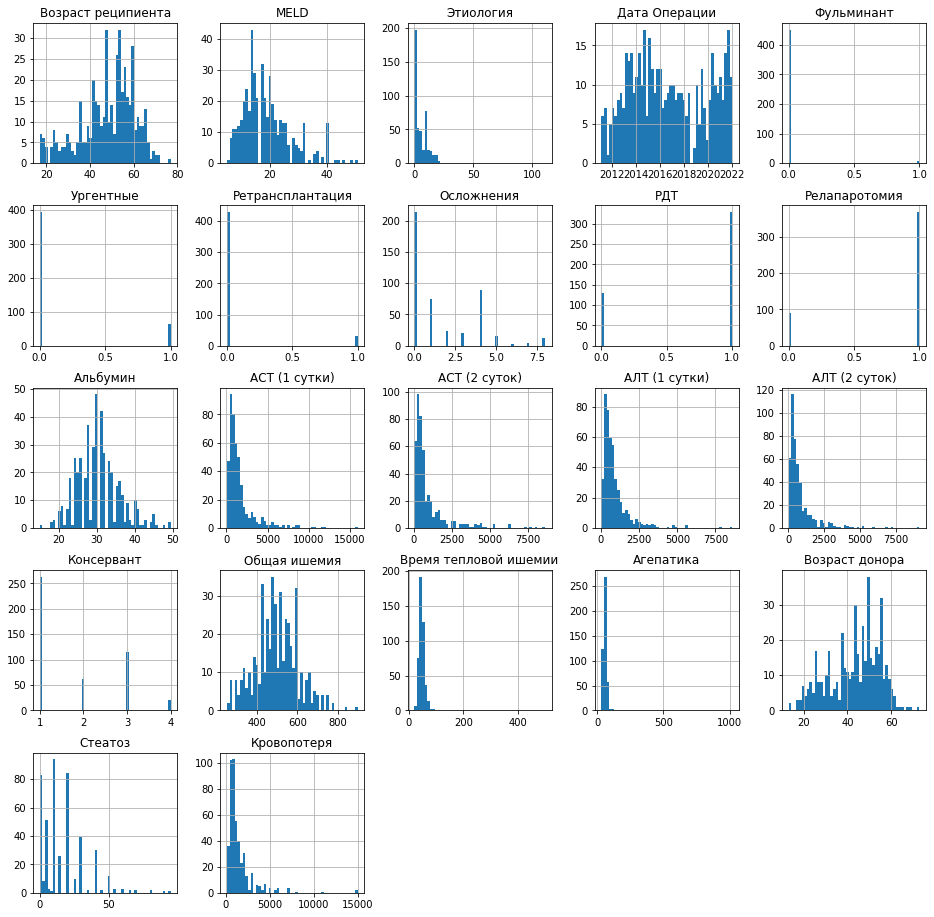

In [10]:
liver_df.hist(bins=50, figsize=(16, 16))

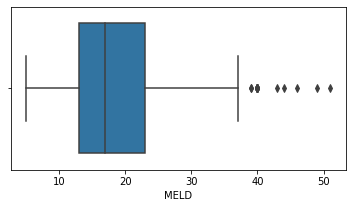

In [11]:
plt.figure(figsize=(6, 3))

sns.boxplot(liver_df['MELD'], whis=1.5)

plt.xlabel('MELD')
plt.show()

In [12]:
liver_df = liver_df[liver_df['MELD']<35]

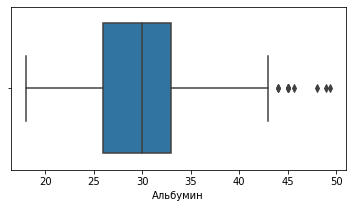

In [13]:
plt.figure(figsize=(6, 3))

sns.boxplot(liver_df['Альбумин'], whis=1.5)

plt.xlabel('Альбумин')
plt.show()

In [14]:
liver_df = liver_df[liver_df['Альбумин']<45]

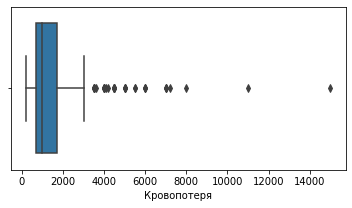

In [15]:
plt.figure(figsize=(6, 3))

sns.boxplot(liver_df['Кровопотеря'], whis=1.5)

plt.xlabel('Кровопотеря')
plt.show()

In [16]:
liver_df = liver_df[liver_df['Кровопотеря']<5000]

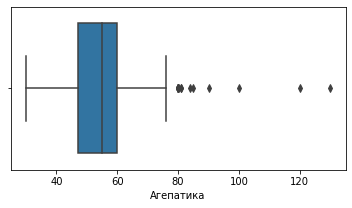

In [17]:
plt.figure(figsize=(6, 3))

sns.boxplot(liver_df['Агепатика'], whis=1.5)

plt.xlabel('Агепатика')
plt.show()

In [18]:
liver_df = liver_df[liver_df['Агепатика']<100]

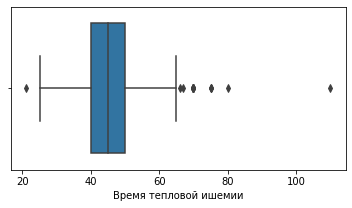

In [19]:
plt.figure(figsize=(6, 3))

sns.boxplot(liver_df['Время тепловой ишемии'], whis=1.5)

plt.xlabel('Время тепловой ишемии')
plt.show()

In [20]:
liver_df = liver_df[liver_df['Время тепловой ишемии']<150]

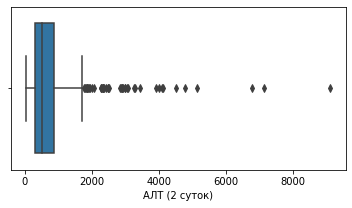

In [21]:
plt.figure(figsize=(6, 3))

sns.boxplot(liver_df['АЛТ (2 суток)'], whis=1.5)

plt.xlabel('АЛТ (2 суток)')
plt.show()

In [22]:
liver_df = liver_df[liver_df['АЛТ (2 суток)']<6000]

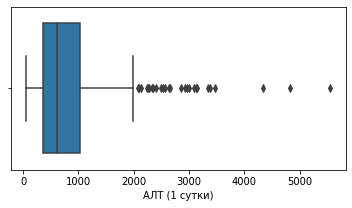

In [23]:
plt.figure(figsize=(6, 3))

sns.boxplot(liver_df['АЛТ (1 сутки)'], whis=1.5)

plt.xlabel('АЛТ (1 сутки)')
plt.show()

In [24]:
liver_df = liver_df[liver_df['АЛТ (1 сутки)']<4000]

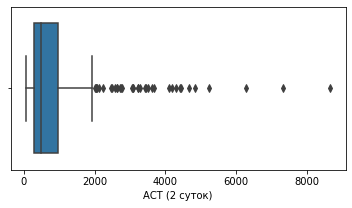

In [25]:
plt.figure(figsize=(6, 3))

sns.boxplot(liver_df['АСТ (2 суток)'], whis=1.5)

plt.xlabel('АСТ (2 суток)')
plt.show()

In [26]:
liver_df = liver_df[liver_df['АСТ (2 суток)']<5000]

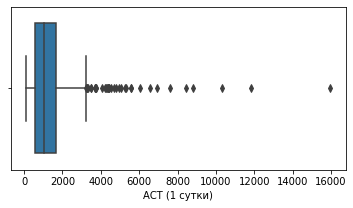

In [27]:
plt.figure(figsize=(6, 3))

sns.boxplot(liver_df['АСТ (1 сутки)'], whis=1.5)

plt.xlabel('АСТ (1 сутки)')
plt.show()

In [28]:
liver_df = liver_df[liver_df['АСТ (1 сутки)']<6000]

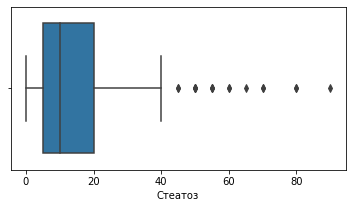

In [29]:
plt.figure(figsize=(6, 3))

sns.boxplot(liver_df['Стеатоз'], whis=1.5)

plt.xlabel('Стеатоз')
plt.show()

Результат после коррекции выбросов, все не убирал, так как некоторые цифры очень важны

In [30]:
liver_df[['Возраст реципиента', 'MELD', 'Альбумин', 'АСТ (1 сутки)', 'АСТ (2 суток)',
       'АЛТ (1 сутки)', 'АЛТ (2 суток)','Общая ишемия',
       'Время тепловой ишемии', 'Агепатика', 'Возраст донора', 'Стеатоз', 'Кровопотеря']].describe()

,Возраст реципиента,MELD,Альбумин,АСТ (1 сутки),АСТ (2 суток),АЛТ (1 сутки),АЛТ (2 суток),Общая ишемия,Время тепловой ишемии,Агепатика,Возраст донора,Стеатоз,Кровопотеря
count,383.000000,383.000000,383.000000,383.000000,383.000000,383.000000,383.000000,383.000000,383.000000,383.000000,383.000000,383.000000,383.000000
mean,48.694517,17.467363,30.065274,1305.550914,735.754569,763.415144,699.968668,490.052219,46.355091,54.866841,42.819843,15.686684,1234.934726
std,12.041949,6.305765,5.190262,1063.798409,775.138540,594.803894,684.347126,104.304189,9.947731,10.732371,11.621492,14.853068,828.394292
min,17.000000,5.000000,18.000000,99.000000,55.000000,52.000000,35.000000,250.000000,21.000000,30.000000,13.000000,0.000000,200.000000
25%,42.000000,13.000000,26.000000,579.500000,275.500000,349.500000,287.500000,420.000000,40.000000,47.000000,35.000000,5.000000,700.000000
50%,51.000000,17.000000,30.000000,1000.000000,461.000000,593.000000,481.000000,490.000000,45.000000,55.000000,45.000000,10.000000,1000.000000
75%,57.000000,21.000000,33.000000,1591.500000,875.000000,963.500000,806.000000,555.000000,50.000000,60.000000,52.000000,20.000000,1500.000000
max,77.000000,34.000000,44.000000,5580.000000,4441.000000,3472.000000,4792.000000,840.000000,110.000000,90.000000,73.000000,90.000000,4500.000000


Категориальные признаки

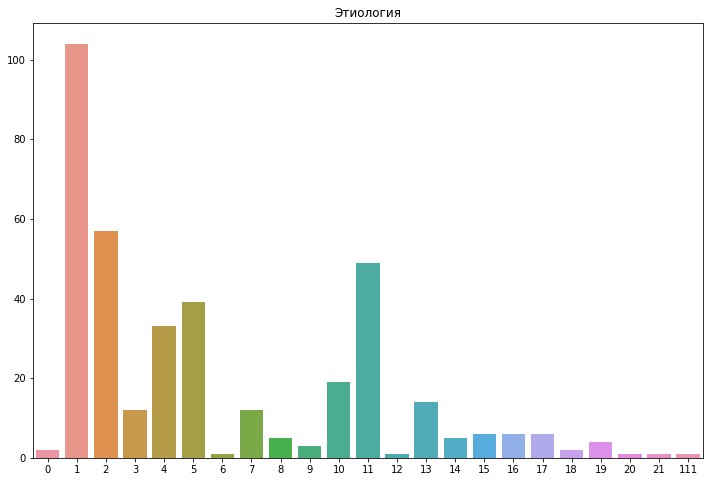

In [31]:
etiology = liver_df['Этиология'].value_counts()
plt.figure(figsize = (12, 8))
plt.title('Этиология')
sns.barplot(etiology.index, etiology.values)
plt.show()

In [32]:
liver_df.loc[liver_df['Этиология'] == 111] = 11 #устранил опечатку

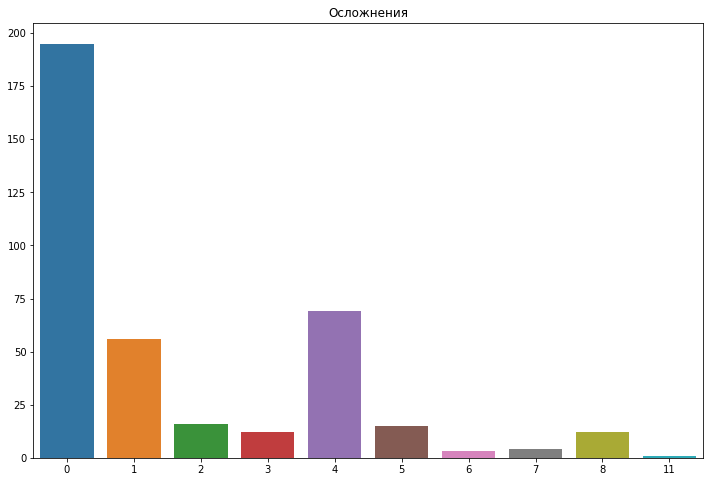

In [33]:
complications = liver_df['Осложнения'].value_counts()
plt.figure(figsize = (12, 8))
plt.title('Осложнения')
sns.barplot(complications.index, complications.values)
plt.show()

In [34]:
liver_df.loc[liver_df['Осложнения'] == 11] = 1 #устранил опечатку

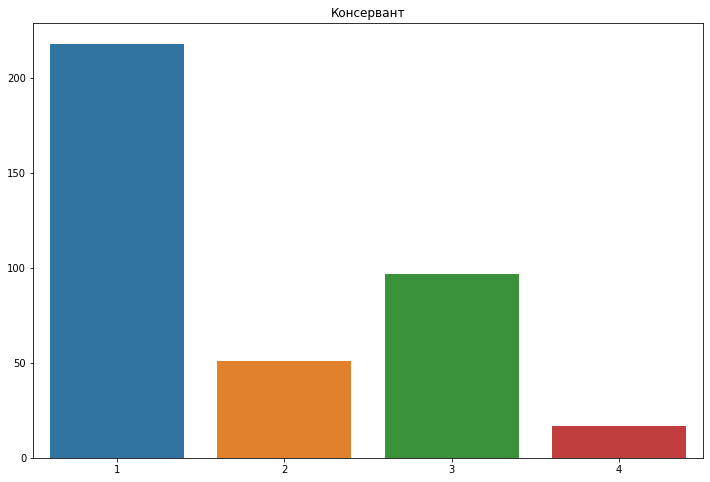

In [35]:
cons = liver_df['Консервант'].value_counts()
plt.figure(figsize = (12, 8))
plt.title('Консервант')
sns.barplot(cons.index, cons.values)
plt.show()

Поиск фичей

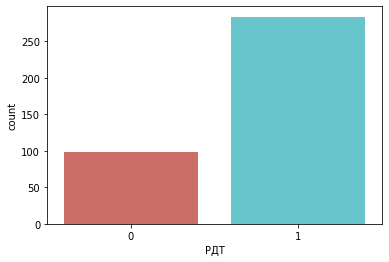

РДТ не развилось(0) 25.848563968668408
РДТ развилось(1) 74.1514360313316


In [36]:
sns.countplot(x = liver_df['РДТ'], palette='hls')
plt.show()

RDT_no = len(liver_df[liver_df['РДТ']==0])
RDT = len(liver_df[liver_df['РДТ']==1])
RDT_no_sub = RDT_no/(RDT_no+RDT)
print("РДТ не развилось(0)", RDT_no_sub*100)
RDT_of_sub = RDT/(RDT_no+RDT)
print("РДТ развилось(1)", RDT_of_sub*100)

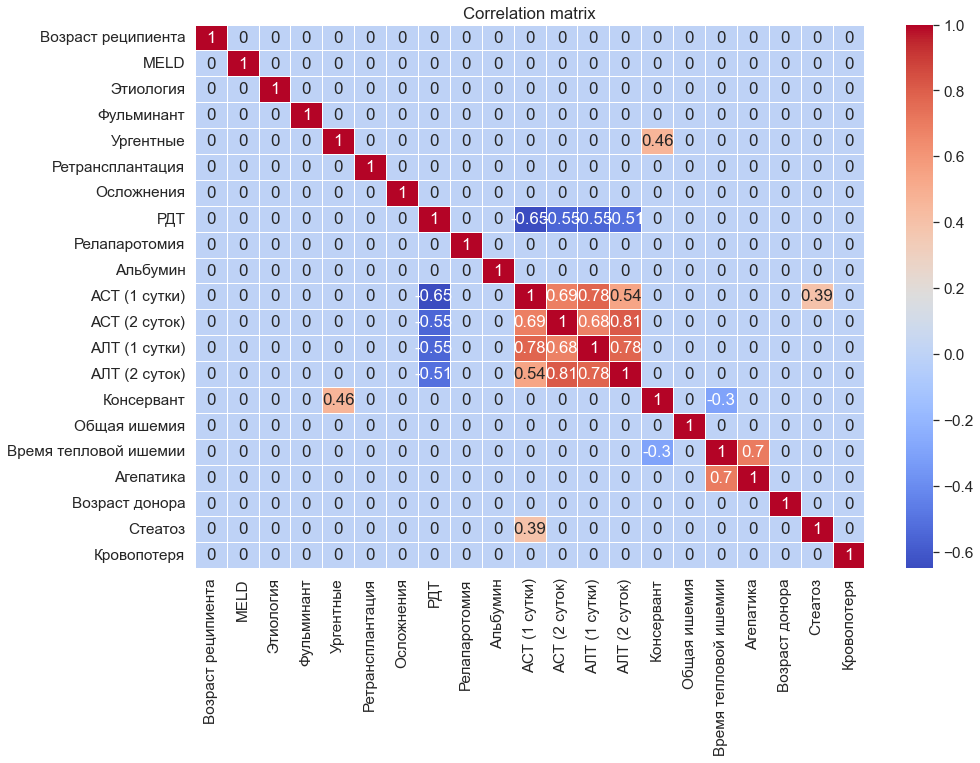

In [37]:
plt.figure(figsize = (15,10))

sns.set(font_scale=1.4)

corr_matrix = liver_df.corr()
corr_matrix = np.round(corr_matrix, 2)
corr_matrix[np.abs(corr_matrix) < 0.3] = 0

sns.heatmap(corr_matrix, annot=True, linewidths=.5, cmap='coolwarm')

plt.title('Correlation matrix')
plt.show()

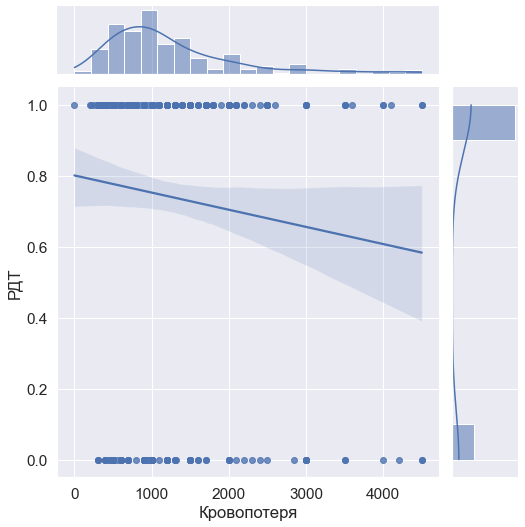

In [38]:
grid = sns.jointplot(liver_df['Кровопотеря'], liver_df['РДТ'], kind='reg')
grid.fig.set_figwidth(8)
grid.fig.set_figheight(8)
plt.show()

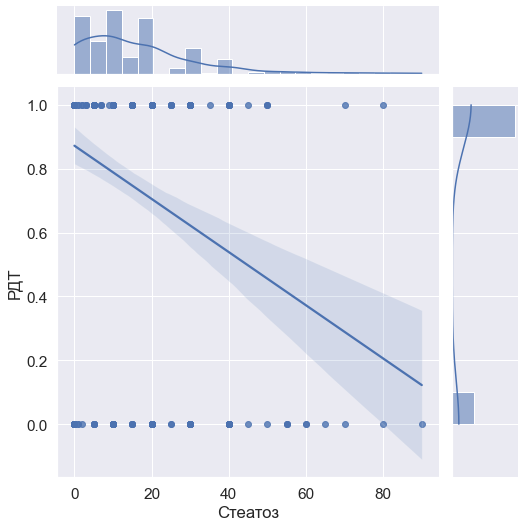

In [39]:
grid = sns.jointplot(liver_df['Стеатоз'], liver_df['РДТ'], kind='reg')
grid.fig.set_figwidth(8)
grid.fig.set_figheight(8)
plt.show()

In [42]:
pointbiserialr(liver_df['Агепатика'], liver_df['РДТ'])

PointbiserialrResult(correlation=-0.10532835444703371, pvalue=0.039368624529448996)

In [43]:
pointbiserialr(liver_df['Общая ишемия'], liver_df['РДТ'])

PointbiserialrResult(correlation=-0.08376028563614304, pvalue=0.10168472510803721)

In [44]:
pointbiserialr(liver_df['Кровопотеря'], liver_df['РДТ'])

PointbiserialrResult(correlation=-0.09160426093989953, pvalue=0.07335148648077594)

In [45]:
pointbiserialr(liver_df['MELD'], liver_df['РДТ'])

PointbiserialrResult(correlation=-0.0008459038032861891, pvalue=0.9868350586773439)

In [46]:
pointbiserialr(liver_df['Возраст донора'], liver_df['РДТ'])

PointbiserialrResult(correlation=-0.03771301097699269, pvalue=0.4617869482494309)

In [47]:
pd.crosstab(liver_df['Фульминант'], liver_df['РДТ'])

РДТ,0,1
Фульминант,,
0,98,281
1,1,3


Сохраняем датасет

In [146]:
liver_df.to_csv('C:\\Users\\Вася\\Desktop\\Ординатура\\База печень.csv', index=False, encoding='utf-8', sep=';')

# Разбиение на train / test

Группируем признаки, необходимые для модели

In [48]:
liver_df.columns.tolist()

['Возраст реципиента',
 'MELD',
 'Этиология',
 'Дата Операции',
 'Фульминант',
 'Ургентные',
 'Ретрансплантация',
 'Осложнения',
 'РДТ',
 'Релапаротомия',
 'Альбумин',
 'АСТ (1 сутки)',
 'АСТ (2 суток)',
 'АЛТ (1 сутки)',
 'АЛТ (2 суток)',
 'Консервант',
 'Общая ишемия',
 'Время тепловой ишемии',
 'Агепатика',
 'Возраст донора',
 'Стеатоз',
 'Кровопотеря']

In [49]:
signs_name = ['Возраст реципиента', 'MELD', 'Этиология','Фульминант', 'Ургентные', 'Ретрансплантация', 'Осложнения',
              'Релапаротомия', 'Альбумин', 'АСТ (1 сутки)', 'АСТ (2 суток)',
              'АЛТ (1 сутки)', 'АЛТ (2 суток)', 'Консервант',
              'Общая ишемия', 'Время тепловой ишемии', 'Агепатика', 
              'Возраст донора','Стеатоз', 'Кровопотеря']

target_name = 'РДТ'

In [50]:
df = liver_df[signs_name + [target_name]]
df.head()

,Возраст реципиента,MELD,Этиология,Фульминант,Ургентные,Ретрансплантация,Осложнения,Релапаротомия,Альбумин,АСТ (1 сутки),...,АЛТ (1 сутки),АЛТ (2 суток),Консервант,Общая ишемия,Время тепловой ишемии,Агепатика,Возраст донора,Стеатоз,Кровопотеря,РДТ
3,34,14,14,0,0,0,0,1,36.0,247,...,266,417.0,1,400.0,50.0,50.0,48,10,500.0,1
4,25,15,1,0,0,0,0,1,35.0,445,...,211,295.0,1,450.0,70.0,70.0,40,0,700.0,1
6,63,25,18,0,0,1,3,1,34.0,2337,...,1609,1559.0,1,480.0,65.0,65.0,50,20,1200.0,0
7,26,16,14,0,0,0,0,1,30.0,351,...,489,327.0,1,320.0,55.0,50.0,28,0,1400.0,1
8,45,21,4,0,0,0,1,1,26.0,264,...,322,357.0,1,495.0,55.0,55.0,19,0,1600.0,1


Разбиение на train и test

In [51]:
X = df[signs_name]
y = df[target_name]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, shuffle=True, random_state=42)

# Построение модели

Учитывая, что показатель, который мне нужно определить бинарный.
Правильно использовать метод логистической регрессии.

In [77]:
# Строим модель, используя все признаки
lr = LogisticRegression(solver="liblinear")

lr.fit(X_train, y_train)

y_pred = lr.predict(X_test)

Проверка качества метода

In [113]:
#  метрику accuracy (точность), метрика качества
accuracy_score(y_test, y_pred)

0.889763779527559

In [114]:
# Делаем предсказание на тренировочном датасете
y_pred_train = lr.predict(X_train)

accuracy_score(y_train, y_pred_train)

0.89453125

In [ ]:
# Точность на двух методах примерно одинакова, значит модель работает корректно.

In [123]:
# Вероятность принадлежности к классу и метрика AUC
y_pred_proba = lr.predict_proba(X_test)
y_pred_proba[:10]

array([[0.16815687, 0.83184313],
       [0.10666575, 0.89333425],
       [0.12914959, 0.87085041],
       [0.07020659, 0.92979341],
       [0.1656114 , 0.8343886 ],
       [0.12865976, 0.87134024],
       [0.1178651 , 0.8821349 ],
       [0.99163482, 0.00836518],
       [0.07640653, 0.92359347],
       [0.11868215, 0.88131785]])

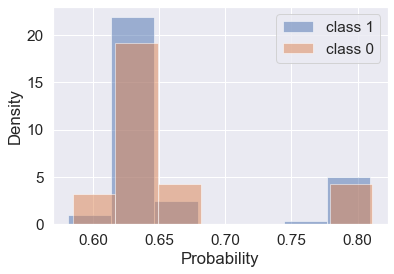

In [101]:
# Построим гистограмму

plt.hist(y_pred_proba[y_test == 1], bins=7, density=True, label='class 1', alpha=0.5)
plt.hist(y_pred_proba[y_test == 0], bins=7, density=True, label='class 0', alpha=0.5)

plt.xlabel("Probability")
plt.ylabel("Density")

plt.legend()

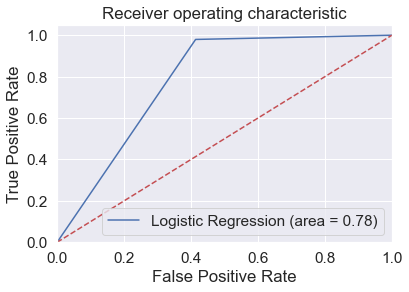

In [102]:
# Строим ROC кривую
logit_roc_auc = roc_auc_score(y_test, y_pred)
fpr, tpr, thresholds = roc_curve(y_test, y_pred)
plt.figure()
plt.plot(fpr, tpr, label='Logistic Regression (area = %0.2f)' % logit_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.savefig('Log_ROC')
plt.show()

Попробуем метод SVC - метод опорных векторов

In [60]:
# Проводим нормализацию признаков

scaler = MinMaxScaler()

X_train = pd.DataFrame(scaler.fit_transform(X_train), columns=X_train.columns)

X_test = pd.DataFrame(scaler.transform(X_test), columns=X_test.columns)

In [143]:
# Обучение модели
clf = SVC(gamma="auto")

clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)
y_pred_train = clf.predict(X_train)

In [84]:
#  метрику accuracy (точность), метрика качества
accuracy_score(y_test, y_pred)

0.889763779527559

In [85]:
# Делаем предсказание на тренировочном датасете
accuracy_score(y_train, y_pred_train)

0.89453125

In [93]:
# Так как выборка несбалансирована, используем другую метрику качества - матрицу ошибок
cm = confusion_matrix(y_test, y_pred)
print(cm)

TP = ((y_pred == 1) & (y_test) == 1).sum()
print('Модель правильно классифицировала', TP)

TN = cm[0, 0]
FP = cm[0, 1]
FN = cm[1, 0]

[[17 12]
 [ 2 96]]
Модель правильно классифицировала 96


In [95]:
precision = TP / (TP + FP)
print('Точность и полнота:', precision)

Точность и полнота: 0.8347826086956521


In [96]:
# Еше один способ определения качества, он как предыдущий, но дает лучший результат
from sklearn.metrics import recall_score

recall_score(y_test, y_pred)

0.9795918367346939

F-мера - комбинирует дву предыдущие метрики

In [112]:
f1_score(y_test, y_pred)

0.9320388349514563

Метод SVC показал лучшие результаты по сравнению с логистической регрессией.

# Оценка признаков

In [150]:
y_pred = pd.DataFrame(zip(X_train.columns, 
                                       y_pred), 
                                   columns=['feature_name', 'importance'])

y_pred.sort_values(by='importance', ascending=False, inplace=True)

In [152]:
y_pred_proba.head

<bound method NDFrame.head of              feature_name  importance
3              Фульминант    0.929793
8                Альбумин    0.923593
1                    MELD    0.893334
10          АСТ (2 суток)    0.892805
19            Кровопотеря    0.891461
14           Общая ишемия    0.885206
15  Время тепловой ишемии    0.884793
6              Осложнения    0.882135
9           АСТ (1 сутки)    0.881318
12          АЛТ (2 суток)    0.879293
16              Агепатика    0.878423
5        Ретрансплантация    0.871340
13             Консервант    0.871242
2               Этиология    0.870850
18                Стеатоз    0.842642
4               Ургентные    0.834389
0      Возраст реципиента    0.831843
17         Возраст донора    0.807808
11          АЛТ (1 сутки)    0.411241
7           Релапаротомия    0.008365>

In [145]:
check_test = pd.DataFrame({
    "y_test": y_test,
    "y_pred": y_pred.flatten(),
})

check_test.tail(10)

,y_test,y_pred
158,1,1
307,1,1
185,1,1
292,1,1
302,1,1
454,1,1
252,0,1
278,0,1
406,1,1
206,1,1


# Сохранение модели

In [154]:
with open('y_pred.pkl','wb') as f:
    pickle.dump(y_pred,f)

In [155]:
liver_df.to_csv('C:\\Users\\Вася\\Desktop\\Ординатура\\База печень.csv', index=False, encoding='utf-8', sep=';')